# Introduction

**[Gett](https://www.gett.com/)**, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

# Tasks
Please complete the following tasks.

## 1. 
Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

### Data imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

data_orders = pd.read_csv("./datasets/data_orders.csv")
data_offers = pd.read_csv("./datasets/data_offers.csv")
data_orders

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN
...,...,...,...,...,...,...,...,...
10711,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0
10712,13:13:55,-0.975372,51.457846,NaN,3000599186962,4,0,4.0
10713,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0
10714,13:16:28,-0.975372,51.457846,NaN,3000599187024,4,0,6.0


### Plot

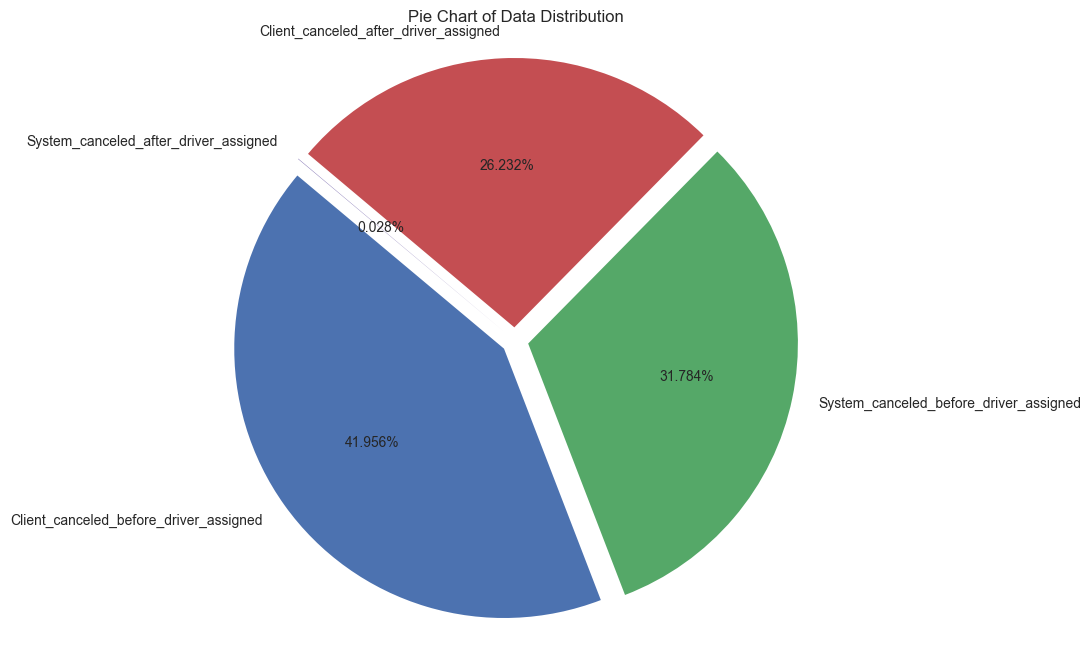

In [2]:
group_counts = data_orders.groupby(["is_driver_assigned_key", "order_status_key"]).size()
Client_canceled_before_driver_assigned = group_counts.iloc[[0]].iloc[0]
System_canceled_before_driver_assigned = group_counts.iloc[[1]].iloc[0]
Client_canceled_after_driver_assigned = group_counts.iloc[[2]].iloc[0]
System_canceled_after_driver_assigned = group_counts.iloc[[3]].iloc[0]

plt.figure(figsize=(8, 8))
plt.style.use("seaborn-v0_8")
plt.pie([Client_canceled_before_driver_assigned, System_canceled_before_driver_assigned,
         Client_canceled_after_driver_assigned, System_canceled_after_driver_assigned],
        labels=["Client_canceled_before_driver_assigned", "System_canceled_before_driver_assigned",
                "Client_canceled_after_driver_assigned", "System_canceled_after_driver_assigned"],
        explode=[0.05, 0.05, 0.05, 0.05], autopct='%1.3f%%', startangle=140)

plt.axis('equal')

plt.title('Pie Chart of Data Distribution')
plt.show()

### Analysis

As we can see from the plot above, the most common reason for failure for an order is the driver not being assigned while order cancelled by client.

## 2.
Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?
### Plot

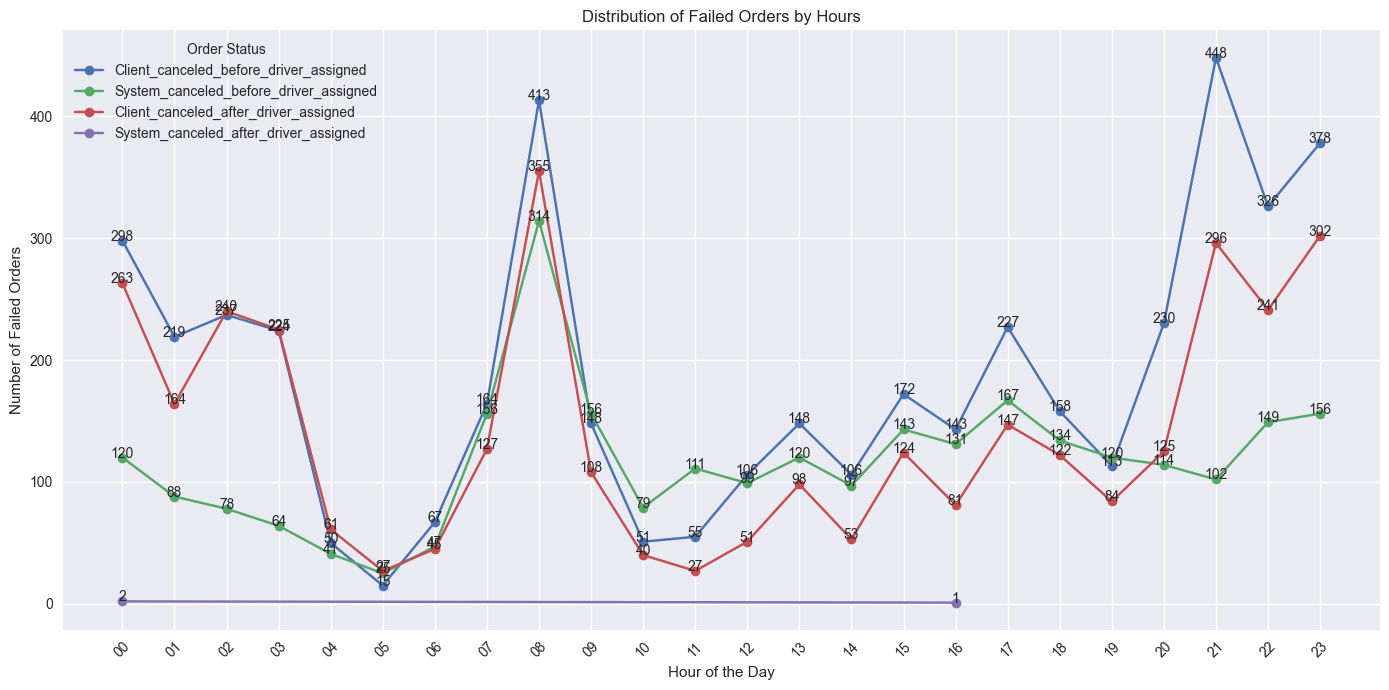

In [3]:
# 创建一个新列来表示订单的小时
data_orders['order_hour'] = [data.split(':')[0] for data in data_orders['order_datetime']]

# 根据订单状态和小时数对订单进行分组，并计算每个状态的订单数量
status_counts = data_orders.groupby(['order_hour', 'order_status_key', 'is_driver_assigned_key']).size()

# 将多级索引转换为 DataFrame，以便于绘制
status_counts_df = status_counts.reset_index(name='counts')
# 绘制折线图
plt.figure(figsize=(14, 7))
label = ["Client_canceled_before_driver_assigned", "System_canceled_before_driver_assigned",
         "Client_canceled_after_driver_assigned", "System_canceled_after_driver_assigned"]
# 为每个状态绘制一条线
i = 0
for status, df in status_counts_df.groupby(['order_status_key', 'is_driver_assigned_key']):
    plt.plot(df['order_hour'], df['counts'], "o-",
             label=label[i])
    i += 1
    for j, count in enumerate(df['counts']):
        plt.text(df['order_hour'].iloc[j], count, str(count), ha='center')

plt.title('Distribution of Failed Orders by Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Failed Orders')
plt.legend(title='Order Status')
plt.grid(True)  # 添加网格线以便于观察

# 旋转 x 轴标签，以便于阅读
plt.xticks(rotation=45)
plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域

plt.show()

### Analysis
Upon examination of the data, we have plotted the distribution of orders by the hour, differentiated by both order_status_key and is_driver_assigned_key. 

Notably, the hours of 8 AM and 9 PM exhibit the highest rates of order cancellations. Considering the temporal context, these peak cancellation times correspond with the morning and evening rush hours, respectively. During these periods, there is a pronounced scarcity of drivers in contrast to the heightened demand from passengers, leading to a surge in cancellations.

## 3.
Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?
### Average time to cancellation

In [4]:
# 计算平均值
not_assigned_group = data_orders.groupby("is_driver_assigned_key").get_group(0)
avg_time_1 = not_assigned_group.groupby("order_hour")['cancellations_time_in_seconds'].mean().reset_index()
do_assigned_group = data_orders.groupby("is_driver_assigned_key").get_group(1)
avg_time_2 = do_assigned_group.groupby("order_hour")['cancellations_time_in_seconds'].mean().reset_index()


In [5]:
# 计算置信区间
def calculate_ci(data):
    # 首先，我们需要计算样本均值和标准差
    sample_mean = data.mean()
    sample_std = data.std()
    sample_size = len(data)
    # 计算自由度
    df = sample_size - 1
    # 计算置信区间
    lower_ci, upper_ci = stats.t.interval(0.95, df, loc=sample_mean, scale=sample_std / np.sqrt(sample_size))
    return lower_ci, upper_ci

datas = data_orders.groupby("is_driver_assigned_key").get_group(0).groupby("order_hour")
not_assigned_ci = []
for data in datas.groups:
    not_assigned_ci.append([data, calculate_ci(datas.get_group(data)['cancellations_time_in_seconds'])])
datas = data_orders.groupby("is_driver_assigned_key").get_group(1).groupby("order_hour")
do_assigned_ci = []
for data in datas.groups:
    do_assigned_ci.append([data, calculate_ci(datas.get_group(data)['cancellations_time_in_seconds'])])


### Plot with confidence intervals

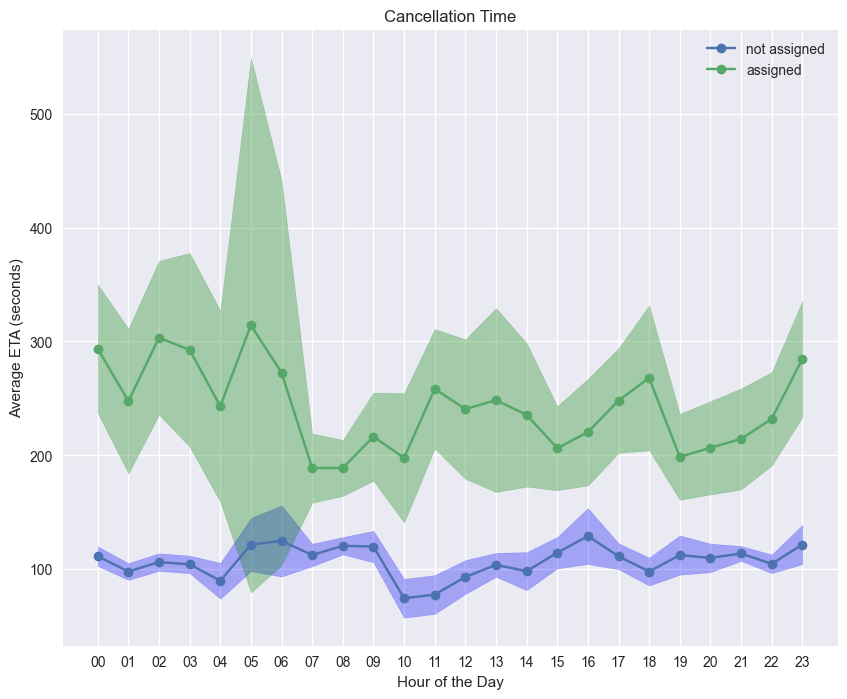

In [6]:
plt.figure(figsize=(10, 8))
# 绘制平均值
plt.plot(avg_time_1['order_hour'], avg_time_1['cancellations_time_in_seconds'], marker='o', label="not assigned")
plt.plot(avg_time_2['order_hour'], avg_time_2['cancellations_time_in_seconds'], marker='o', label="assigned")
# 绘制置信区间
plt.fill_between([row[0] for row in not_assigned_ci], [row[1][0] for row in not_assigned_ci],
                 [row[1][1] for row in not_assigned_ci], alpha=0.3, color='blue')
plt.fill_between([row[0] for row in do_assigned_ci], [row[1][0] for row in do_assigned_ci],
                 [row[1][1] for row in do_assigned_ci], alpha=0.3, color="green")

plt.title('Cancellation Time')
plt.legend()
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA (seconds)')
plt.show()

### Plot with confidence intervals and scatter

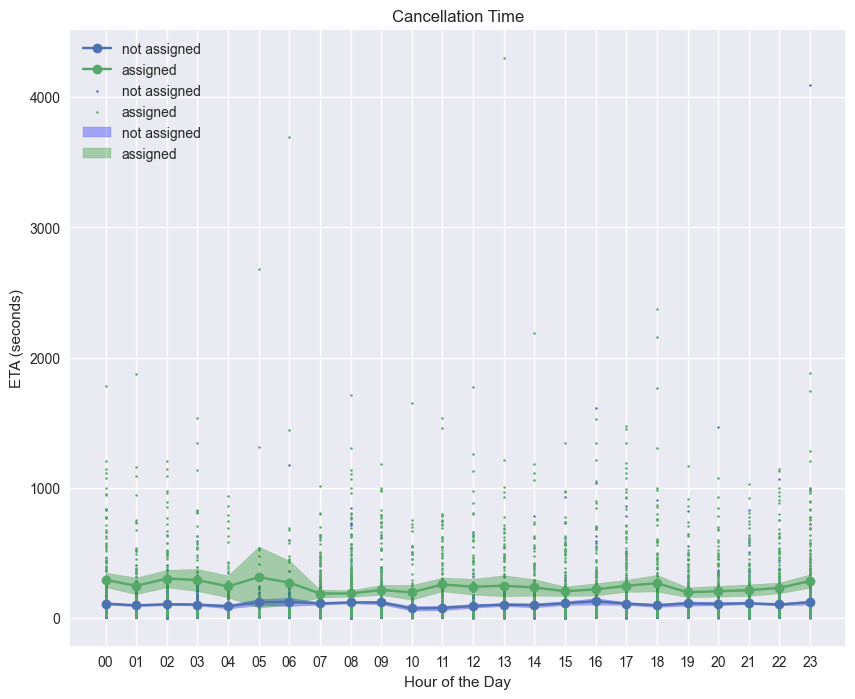

In [7]:
plt.figure(figsize=(10, 8))
# 绘制平均值
plt.plot(avg_time_1['order_hour'], avg_time_1['cancellations_time_in_seconds'], marker='o', label="not assigned")
plt.plot(avg_time_2['order_hour'], avg_time_2['cancellations_time_in_seconds'], marker='o', label="assigned")
# 绘制散点
plt.scatter(not_assigned_group['order_hour'], not_assigned_group['cancellations_time_in_seconds'], s=2,
            label="not assigned")
plt.scatter(do_assigned_group['order_hour'], do_assigned_group['cancellations_time_in_seconds'], s=2, label="assigned")
# 绘制置信区间
plt.fill_between([row[0] for row in not_assigned_ci], [row[1][0] for row in not_assigned_ci],
                 [row[1][1] for row in not_assigned_ci], alpha=0.3, color='blue', label="not assigned")
plt.fill_between([row[0] for row in do_assigned_ci], [row[1][0] for row in do_assigned_ci],
                 [row[1][1] for row in do_assigned_ci], alpha=0.3, color="green", label="assigned")

plt.title('Cancellation Time')
plt.legend()
plt.xlabel('Hour of the Day')
plt.ylabel('ETA (seconds)')
plt.show()

### Clean data

In [8]:
not_assigned_group_clean = pd.DataFrame(columns=['order_hour', 'cancellation_time'])
for row in not_assigned_group.iterrows():
    if (not_assigned_ci[int(row[1]['order_hour'])][1][0] < row[1]['cancellations_time_in_seconds']) & (
            not_assigned_ci[int(row[1]['order_hour'])][1][1] > row[1]['cancellations_time_in_seconds']):
        new_row = {'order_hour': row[1]['order_hour'], 'cancellation_time': row[1]['cancellations_time_in_seconds']}
        not_assigned_group_clean = not_assigned_group_clean._append(new_row, ignore_index=True)
do_assigned_group_clean = pd.DataFrame(columns=['order_hour', 'cancellation_time'])
for row in do_assigned_group.iterrows():
    if (do_assigned_ci[int(row[1]['order_hour'])][1][0] < row[1]['cancellations_time_in_seconds']) & (
            do_assigned_ci[int(row[1]['order_hour'])][1][1] > row[1]['cancellations_time_in_seconds']):
        new_row = {'order_hour': row[1]['order_hour'], 'cancellation_time': row[1]['cancellations_time_in_seconds']}
        do_assigned_group_clean = do_assigned_group_clean._append(new_row, ignore_index=True)

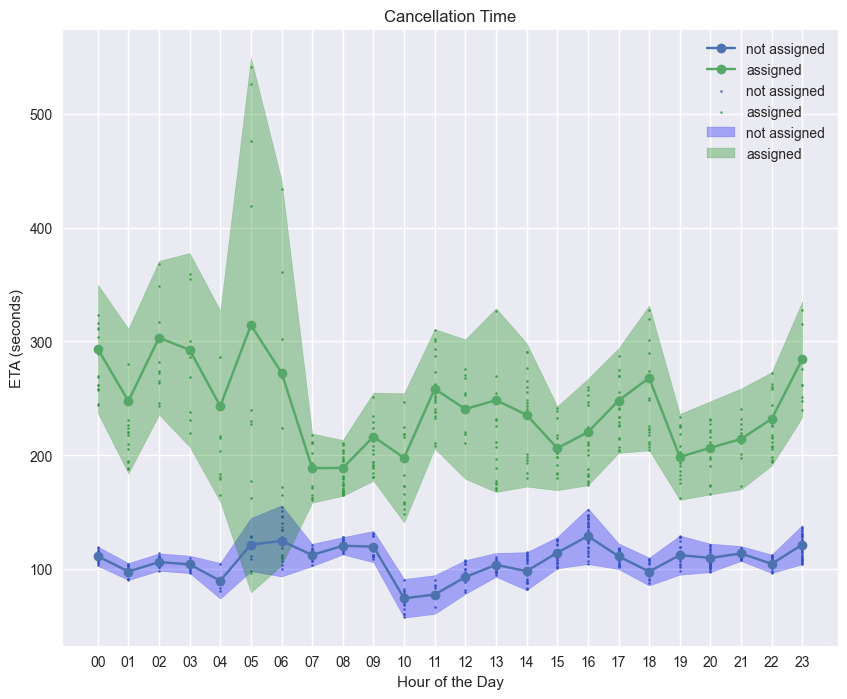

In [9]:
plt.figure(figsize=(10, 8))
# 绘制平均值
plt.plot(avg_time_1['order_hour'], avg_time_1['cancellations_time_in_seconds'], marker='o', label="not assigned")
plt.plot(avg_time_2['order_hour'], avg_time_2['cancellations_time_in_seconds'], marker='o', label="assigned")
# 绘制散点
plt.scatter(not_assigned_group_clean['order_hour'], not_assigned_group_clean['cancellation_time'], s=2,
            label="not assigned")
plt.scatter(do_assigned_group_clean['order_hour'], do_assigned_group_clean['cancellation_time'], s=2, label="assigned")
# 绘制置信区间
plt.fill_between([row[0] for row in not_assigned_ci], [row[1][0] for row in not_assigned_ci],
                 [row[1][1] for row in not_assigned_ci], alpha=0.3, color='blue', label="not assigned")
plt.fill_between([row[0] for row in do_assigned_ci], [row[1][0] for row in do_assigned_ci],
                 [row[1][1] for row in do_assigned_ci], alpha=0.3, color="green", label="assigned")

plt.title('Cancellation Time')
plt.legend()
plt.xlabel('Hour of the Day')
plt.ylabel('ETA (seconds)')
plt.show()

### Analysis
I found that approximately 10% of the data points are located in the tails of the data distribution, indicating that the data distribution is highly skewed and does not conform to a normal distribution. Therefore, I have decided not to remove these data points.
## 4.
Plot the distribution of average ETA by hours. How can this plot be explained?
### Drop the data NA values

In [10]:
data_orders.dropna()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,order_hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13
13,16:55:28,-0.950683,51.451368,538.0,3000583016613,4,1,188.0,16
14,00:59:26,-0.937006,51.448696,179.0,3000582566041,4,1,316.0,00
...,...,...,...,...,...,...,...,...,...
10701,23:53:09,-0.976553,51.455485,178.0,3000589481691,4,1,833.0,23
10703,13:15:55,-0.975372,51.457846,60.0,3000599187005,4,1,28.0,13
10704,13:12:51,-0.975372,51.457846,60.0,3000599186936,4,1,59.0,13
10713,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0,13


### Average and confidence interval calculate

In [11]:
data_orderss = data_orders.dropna()
# 计算平均值
avg_time = data_orderss.groupby("order_hour")['m_order_eta'].mean().reset_index()

In [12]:
import scipy.stats as stats
import numpy as np
# 计算置信区间
def calculate_ci(data):
    # 首先，我们需要计算样本均值和标准差
    sample_mean = data.mean()
    sample_std = data.std()
    sample_size = len(data)
    # 计算自由度
    df = sample_size - 1
    # 计算置信区间
    lower_ci, upper_ci = stats.t.interval(0.95, df, loc=sample_mean, scale=sample_std / np.sqrt(sample_size))
    return lower_ci, upper_ci
datas = data_orderss.groupby("order_hour")
assigned_ci = []
for data in datas.groups:
    assigned_ci.append([data, calculate_ci(datas.get_group(data)['m_order_eta'])])

### Plot with confidence intervals and scatter

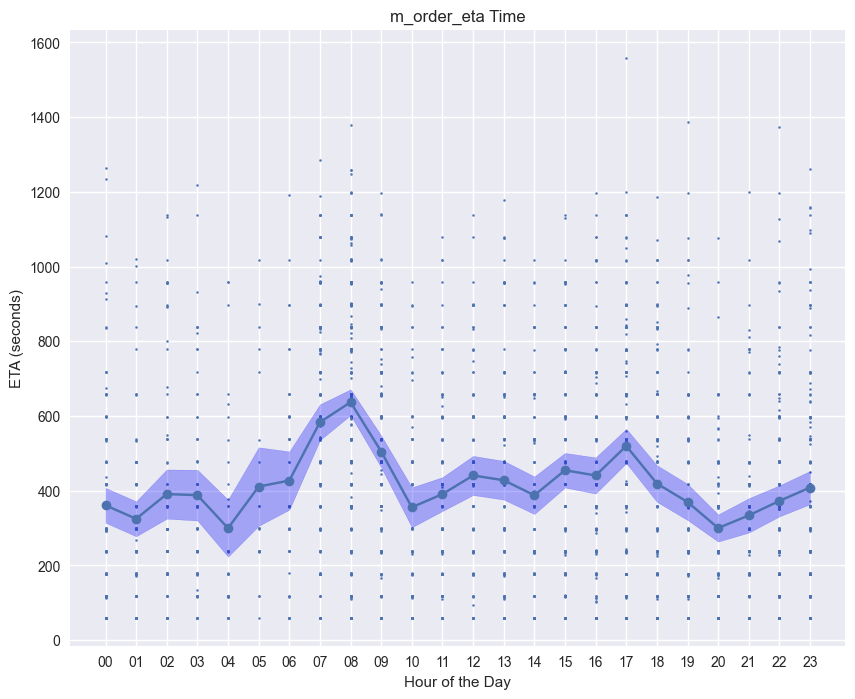

In [13]:
plt.figure(figsize=(10, 8))
# 绘制平均值
plt.plot(avg_time['order_hour'], avg_time['m_order_eta'], marker='o')
# 绘制散点
plt.scatter(data_orderss['order_hour'], data_orderss['m_order_eta'], s=2) \
    # 绘制置信区间
plt.fill_between([row[0] for row in assigned_ci], [row[1][0] for row in assigned_ci],
                 [row[1][1] for row in assigned_ci], alpha=0.3, color='blue')
plt.title('m_order_eta Time')
plt.xlabel('Hour of the Day')
plt.ylabel('ETA (seconds)')
plt.show()

### Analysis 
Orders with an average arrival time of 5-10 minutes are more likely to be canceled; due to the influence of the morning and evening rush hours, people can tolerate longer arrival times at 9 a.m. and 5 p.m.
## 5.
**BONUS** Hexagons. Using the [h3](https://github.com/uber/h3-py) and [folium](https://python-visualization.github.io/folium/latest/) packages, calculate how many sizes [8 hexes](https://h3geo.org/#/documentation/core-library/resolution-table) contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.
### Get top 80%


In [14]:
import h3
import folium

# 找到h3坐标
data_orders['location'] = data_orders.apply(lambda x: h3.geo_to_h3(x['origin_latitude'], x['origin_longitude'], 8),axis=1)
# 点数儿，默认降序排列
hex_order_counts = data_orders['location'].value_counts()
# 累计！
cumulative = hex_order_counts.cumsum()
# 前80%
top80 = cumulative[cumulative <= cumulative[-1] * 0.8].index
print(len(top80))
top80

23


Index(['88195d2b1dfffff', '88195d2b1bfffff', '88195d2b15fffff',
       '88195d2b11fffff', '88195d2b19fffff', '88195d284dfffff',
       '88195d2a27fffff', '88195d2b0bfffff', '88195d2a25fffff',
       '88195d2b13fffff', '88195d2b03fffff', '88195d2b17fffff',
       '88195d2b39fffff', '88195d2861fffff', '88195d2a21fffff',
       '88195d2b3dfffff', '88195d2b31fffff', '88195d2869fffff',
       '88195d2b3bfffff', '88195d2b51fffff', '88195d2b57fffff',
       '88195d2a23fffff', '88195d2b55fffff'],
      dtype='object', name='location')

### Make map

In [15]:
# 新建图
map = folium.Map()

# 颜色根据订单量决定颜色深浅
def color_mapping(value, min_v, max_v):
    red_channel = ((max_v - value) / (max_v - min_v)) * 255
    red_channel = int(max(0, min(255, red_channel)))
    return f'#ff{red_channel:02x}00'
# 添加80%的六边形为梯度颜色
for hhh in top80:
    order_count = hex_order_counts[hhh]
    fill_color = color_mapping(order_count, hex_order_counts.values.min(), hex_order_counts.values.max())
    center = h3.h3_to_geo(hhh)
    polygon = folium.Polygon(locations=[h3.h3_to_geo_boundary(hhh)], color='grey', fill_color=fill_color)
    polygon.add_to(map)
# 添加剩下的六边形为灰色
for hhh in hex_order_counts.index:
    if hhh not in top80:
        center = h3.h3_to_geo(hhh)
        polygon = folium.Polygon(locations=[h3.h3_to_geo_boundary(hhh)], color='grey', fill_color='grey')
        polygon.add_to(map)

In [16]:
map.save('poly.html')

### Map

![Map Image](map.png)